In [1]:
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import statsmodels.api as sm
import scipy as sp

# Simple Ordinary Least Squares Regression {-}

## Problem 0  {-}

Load the auto data set into Pandas.

In [2]:
df = pd.read_csv('Auto.csv')

### Part A {-}

The data set has 392 observations.

In [3]:
n = len(df)

In [4]:
n

392

### Part B {-}

The data set has the following columns.

In [5]:
cols = list(df.columns)

In [6]:
cols

['mpg',
 'cylinders',
 'displacement',
 'horsepower',
 'weight',
 'acceleration',
 'year',
 'origin',
 'name']

### Part C {-}

Here is a scatter plot of each column against every other column pairwise.

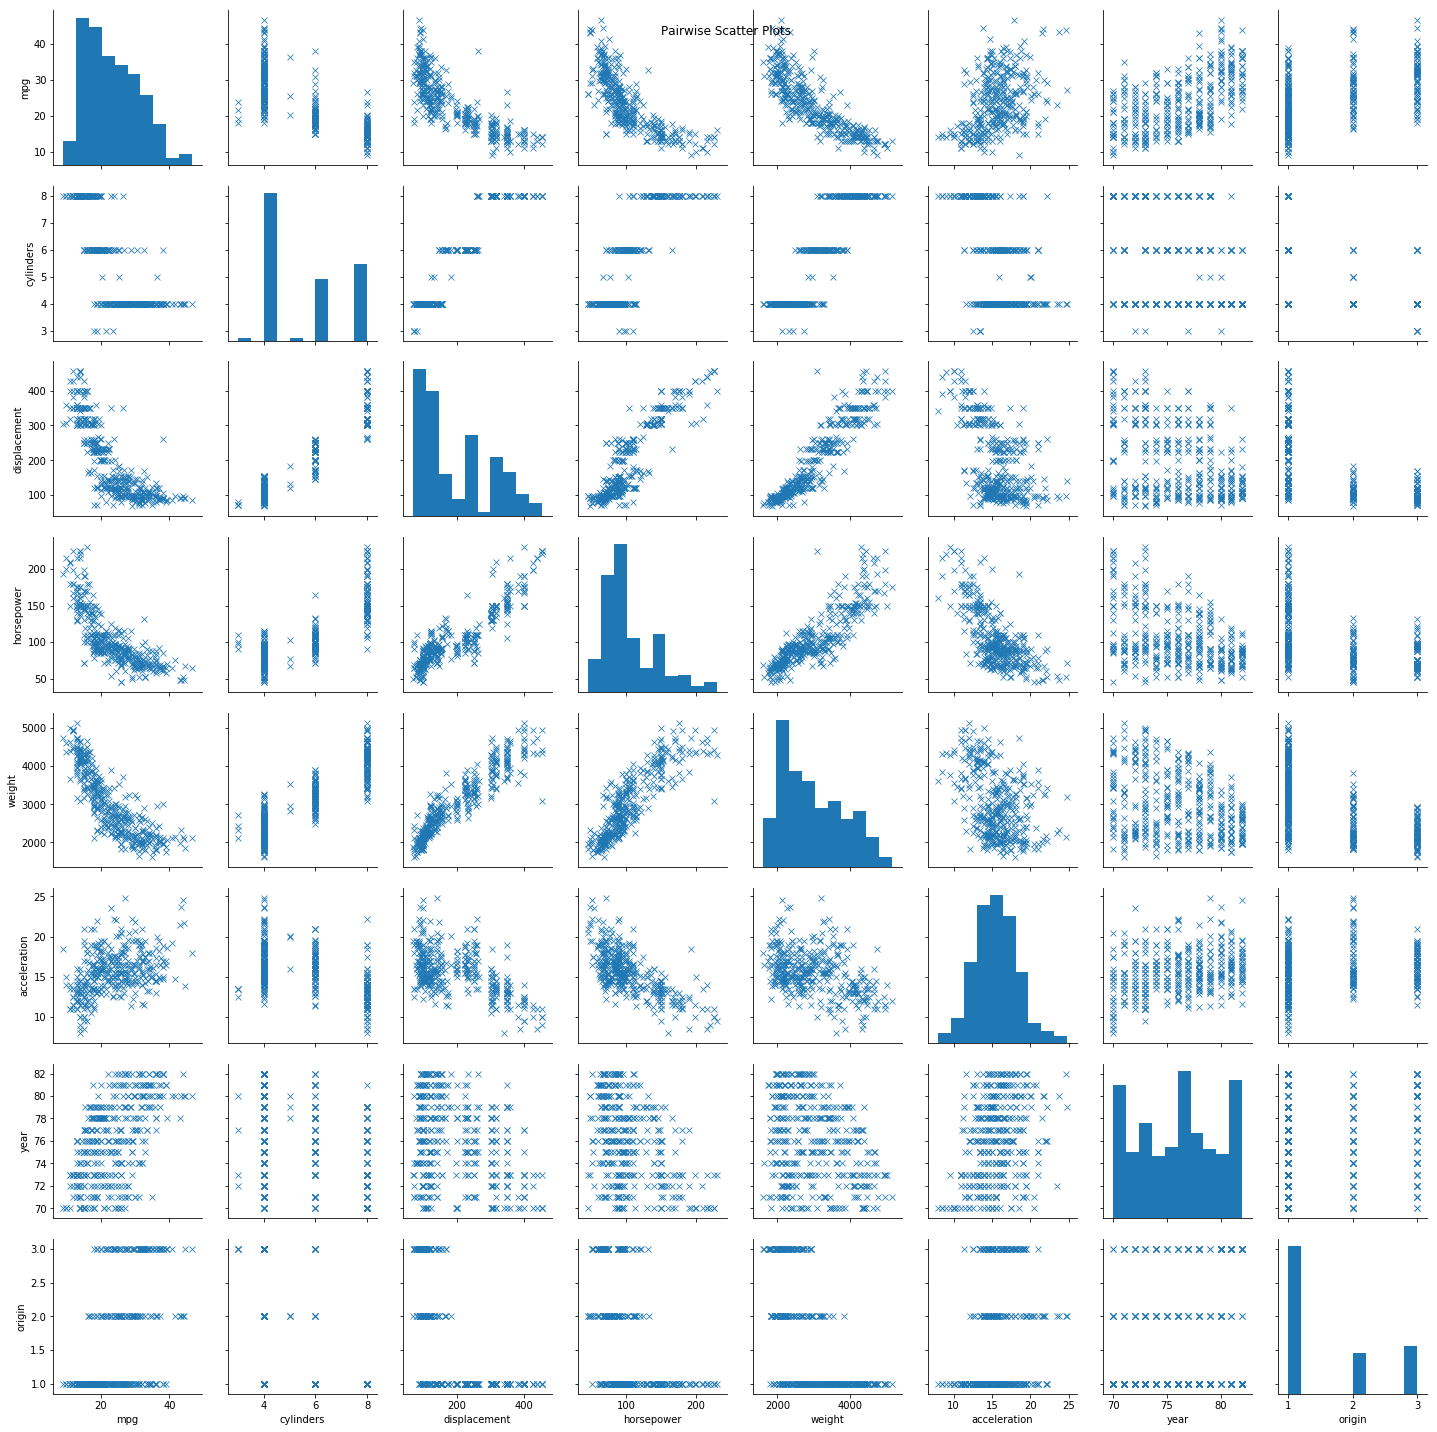

In [7]:
sns.pairplot(df, markers=['x'])
_ = plt.suptitle('Pairwise Scatter Plots')

### Part D {-}

Here are the correlation plots between all columns.

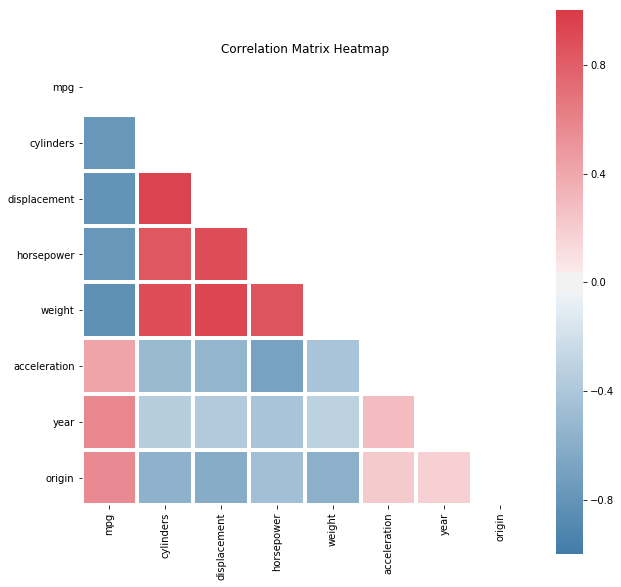

In [8]:
correlation = df.corr()

mask = np.zeros(correlation.shape, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10, 10))

sns.heatmap(correlation, mask=mask, cmap=sns.diverging_palette(240, 10, 
            as_cmap=True), vmin=-1, vmax=1, center=0, square=True, 
            linewidths=3)

_ = plt.title('Correlation Matrix Heatmap')

### Part E {-}

To determine which columns have concerning levels of multicollinearity, we construct a lower triangular matrix of variance inflation factors.

In [9]:
corr = correlation.values
corr[np.triu_indices_from(corr)] = 0

vif = 1 / (1 - corr ** 2)

Using the common cutoff of $5$ for concerning levels of multicollinearity, we can identify the column pairs of interest.

In [10]:
vif_thresh = 5

[(cols[i], cols[j]) for i, j in zip(np.where(vif > vif_thresh)[0], 
                                    np.where(vif > vif_thresh)[1])]

[('displacement', 'cylinders'),
 ('horsepower', 'displacement'),
 ('weight', 'cylinders'),
 ('weight', 'displacement')]

### Part F {-}

To split the data into a train and test set, we first shuffle and then split.

In [11]:
df_shuffled = df.sample(frac=1).reset_index(drop=True)

In [12]:
split_point = int(n * 0.70)

In [13]:
df_train = df_shuffled[:split_point].copy()
df_test = df_shuffled[split_point:].copy()

## Problem 1 {-}

### Part A {-}

We can use `statsmodels` implementation of ordinary least squares to create a model for the regression of `mpg` on `horsepower`.

In [14]:
sv_model = sm.OLS(df_train['mpg'], sm.add_constant(df_train['horsepower']))

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### Part B {-}

Using this model, we fit to the data.

In [15]:
sv_results = sv_model.fit()

### Part C {-}

We observe the results from running the regression.

In [16]:
print(sv_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     347.8
Date:                Wed, 20 Mar 2019   Prob (F-statistic):           1.46e-50
Time:                        21:44:02   Log-Likelihood:                -831.94
No. Observations:                 274   AIC:                             1668.
Df Residuals:                     272   BIC:                             1675.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         38.7406      0.894     43.320      0.0

### Part D {-}

#### Part I {-}

Looking at the $p$-value for the `horsepower` coefficient, we can determine if it is statistically significant.

In [17]:
sv_results.pvalues

const         4.372793e-124
horsepower     1.456463e-50
dtype: float64

Since the $p$-value is significantly less than $\alpha = 0.05$, we fail to reject the null hypothesis at the $0.05$ significance level that `horsepower` has no effect on `mpg`.

#### Part II {-}

The goodness of fit is determined from the $R^2$ value.

In [18]:
sv_results.rsquared

0.5611513074276913

The $R^2$ value is approximately $0.61$. Since this is more than halfway between $0$ and $1$, this is a moderate fit of the data, but definitely has room for improvement.

### Part E {-}

We can use the results of the regression fit to predict our training outputs.

In [19]:
sv_y_hat = sv_results.predict(sm.add_constant(df_train['horsepower']))

### Part F {-}

We can plot the results of the prediction against the actual data.

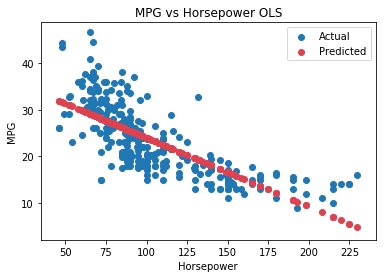

In [20]:
plt.scatter(df_train['horsepower'], df_train['mpg'], label='Actual')
plt.scatter(df_train['horsepower'], sv_y_hat, color='#DE4250',
            label='Predicted')

plt.legend()
plt.title('MPG vs Horsepower OLS')
plt.ylabel('MPG')
_ = plt.xlabel('Horsepower')

### Part G {-}

It does not appear that the linear regression does justice to the data. The `mpg` for larger `horsepower` values in particular doesn't look accurate. It seems like a polynomial feature transformation of degree $2$ would do better.

### Part H {-}

We can extract the residuals from the `sv_results`.

In [21]:
sv_resid = sv_results.resid

### Part I {-}

We can plot the residuals of the regression with respect to `horsepower`.

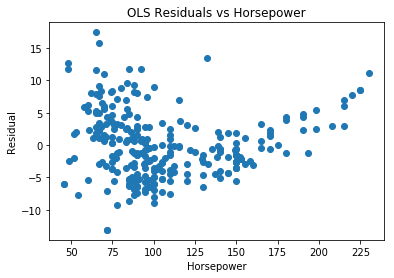

In [22]:
plt.scatter(df_train['horsepower'], sv_resid)

plt.title('OLS Residuals vs Horsepower')
plt.ylabel('Residual')
_ = plt.xlabel('Horsepower')

### Part J {-}

We can plot a histogram of the residuals.

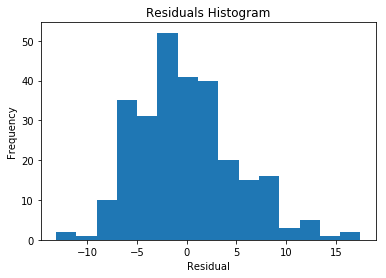

In [23]:
plt.hist(sv_resid, bins=15)

plt.title('Residuals Histogram')
plt.ylabel('Frequency')
_ = plt.xlabel('Residual')

### Part K {-}

We can plot a QQ-plot vs the Normal distribution. 

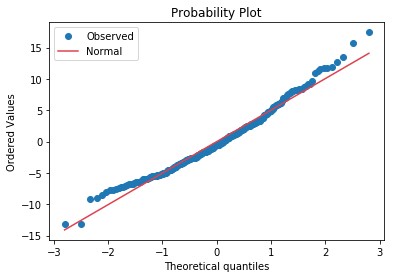

In [24]:
_, ax = plt.subplots()

sp.stats.probplot(sv_resid, plot=ax)

ax.get_lines()[0].set_color('#1F78B4')
ax.get_lines()[1].set_color('#DE4250')

ax.get_lines()[0].set_label('Observed')
ax.get_lines()[1].set_label('Normal')

_ = plt.legend()

### Part L {-}

From the plots, it seems like the residuals are very slightly skewed to the left. However, it doesn't seem like it will be much of an issue. Thus, I would argue that the residuals are approximately normally distributed.

## Problem 2 {-}

### Part A {-}

We introduce a squared term of `horsepower` to our regression.

In [25]:
df['horsepower^2'] = df['horsepower'] ** 2

Now we update the training and testing data similarly maintaining the original split.

In [26]:
df_train['horsepower^2'] = df_train['horsepower'] ** 2
df_test['horsepower^2'] = df_test['horsepower'] ** 2

### Part B {-}

We can confirm that the new column has been added.

In [27]:
cols = list(df.columns)

In [28]:
cols

['mpg',
 'cylinders',
 'displacement',
 'horsepower',
 'weight',
 'acceleration',
 'year',
 'origin',
 'name',
 'horsepower^2']

### Part C {-}

We run a new regression model with the new power feature.

In [29]:
mv_model = sm.OLS(df_train['mpg'], sm.add_constant(df_train[['horsepower', 
                                                             'horsepower^2']]))
mv_results = mv_model.fit()
print(mv_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     236.9
Date:                Wed, 20 Mar 2019   Prob (F-statistic):           3.18e-60
Time:                        21:44:04   Log-Likelihood:                -806.25
No. Observations:                 274   AIC:                             1619.
Df Residuals:                     271   BIC:                             1629.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           54.6149      2.275     24.007   

### Part D {-}

We predict the results of a our training samples and extract the residuals.

In [30]:
mv_y_hat = mv_results.predict(sm.add_constant(df_train[['horsepower', 
                                                        'horsepower^2']]))
mv_resid = mv_results.resid

### Part E {-}

Once again, we plot the predictions against the actual data.

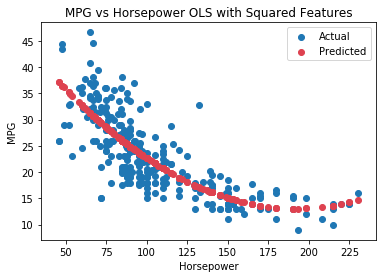

In [31]:
plt.scatter(df_train['horsepower'], df_train['mpg'], label='Actual')
plt.scatter(df_train['horsepower'], mv_y_hat, color='#DE4250',
            label='Predicted')

plt.legend()
plt.title('MPG vs Horsepower OLS with Squared Features')
plt.ylabel('MPG')
_ = plt.xlabel('Horsepower')

### Part F {-}

It definitely appears appears like the model does a better job of representing the relationship between `mpg` and `horsepower`. In particular, the higher `horsepower` values seem to be predicted much more accurately.

### Part G {-}

We can examine a histogram of the residuals.

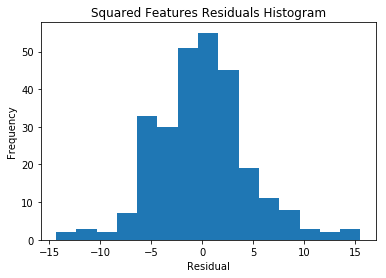

In [32]:
plt.hist(mv_resid, bins=15)

plt.title('Squared Features Residuals Histogram')
plt.ylabel('Frequency')
_ = plt.xlabel('Residual')

### Part H {-}

We can again view a QQ-plot vs the Normal distribution.

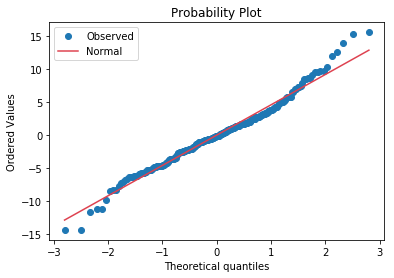

In [33]:
_, ax = plt.subplots()

sp.stats.probplot(mv_resid, plot=ax)

ax.get_lines()[0].set_color('#1F78B4')
ax.get_lines()[1].set_color('#DE4250')

ax.get_lines()[0].set_label('Observed')
ax.get_lines()[1].set_label('Normal')

_ = plt.legend()

### Part I {-}

It appears that the residuals are more normally distributed that before. However, the tails seem to be a bit thinner than a Normal distribution.

### Part J {-}

We can create a function `train_test_split` that will split the data into two parts.

In [34]:
def train_test_split(df, frac):
    """Takes a data frame, shuffles it, and splits it into a training and 
    testing portion.
    
    Args:
        df (DataFrame): A Pandas data frame to split into training and
            testing portions.
        frac (float): A fraction of the data frame to use for training.
        
    Returns:
        DataFrame: A training Pandas data frame of the original data.
        DataFrame: A testing Pandas data frame of the original data.

    """
    n = len(df)
    
    # Take a random sample of all the points in the original data frame
    df_shuffled = df.sample(frac=1).reset_index(drop=True)
    
    # Determine the split index from `frac`
    split_point = int(n * frac)
    
    # Return copies of the slices of the data (otherwise NumPy will 
    # complain later)
    return df_shuffled[:split_point].copy(), \
           df_shuffled[split_point:].copy()

### Part K {-}

We use this method `train_test_split` to create $10$ random subsets and train both the single and multi variable regression on each subset and compare the average mean-squared error for each.

In [35]:
sv_avg_mse = 0
mv_avg_mse = 0

for df_train, df_test in [train_test_split(df, 0.70) for _ in range(10)]:
        
    sv_results = sm.OLS(df_train['mpg'], 
                        sm.add_constant(df_train['horsepower'])).fit()
    mv_results = sm.OLS(df_train['mpg'], 
                        sm.add_constant(df_train[['horsepower', 
                                                  'horsepower^2']])).fit()
    
    sv_y_hat = sv_results.predict(sm.add_constant(df_test['horsepower']))
    mv_y_hat = mv_results.predict(sm.add_constant(df_test[['horsepower', 
                                                           'horsepower^2']]))
    
    sv_avg_mse += np.mean((sv_y_hat.values - df_test['mpg'].values) ** 2)
    mv_avg_mse += np.mean((mv_y_hat.values - df_test['mpg'].values) ** 2)

sv_avg_mse /= 10
mv_avg_mse /= 10

In [36]:
sv_avg_mse, mv_avg_mse

(23.842692291699077, 19.72882767062908)

### Part L {-}

Just by looking at the plots of the regression, we already felt like the multivariable regression was a better fit of the data. This notion was validated using the repeated train-test split to approximate the mean-squared error on unseen test points. Since the multivariable model appears to fit better and has a lower mean-squared error on unseen data, we should choose the multivariable regression over the single variable regression.